### Here we transform the NetCDF file into standard lists for further analyses 
#### We regrid the spatial resolution onto 2°×2°
#### Historical O${_3}$ simulations 1850-2014

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import iris

#### Prescribe the key parameters: 
##### i) target years for analysis (e.g. Y = 5 for five most recent years 2010-2014)
##### ii) ideal spatial resolutions (e.g. 180×90 grids)
###### These parameters are prescribed arbitrarily

In [2]:
Y = 5
lon = 180
lat = 90

#### Define the 1°×1° new spatial resolution for regridding (centred coordinates)

In [3]:
res_lon = 360/lon
res_lat = 180/lat
sample_points = [('longitude', np.linspace(0+res_lon/2, 360-res_lon/2, lon)),
                 ('latitude',  np.linspace(-90+res_lat/2, 90-res_lat/2, lat))]

In [4]:
sample_points

[('longitude',
  array([  1.,   3.,   5.,   7.,   9.,  11.,  13.,  15.,  17.,  19.,  21.,
          23.,  25.,  27.,  29.,  31.,  33.,  35.,  37.,  39.,  41.,  43.,
          45.,  47.,  49.,  51.,  53.,  55.,  57.,  59.,  61.,  63.,  65.,
          67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,  83.,  85.,  87.,
          89.,  91.,  93.,  95.,  97.,  99., 101., 103., 105., 107., 109.,
         111., 113., 115., 117., 119., 121., 123., 125., 127., 129., 131.,
         133., 135., 137., 139., 141., 143., 145., 147., 149., 151., 153.,
         155., 157., 159., 161., 163., 165., 167., 169., 171., 173., 175.,
         177., 179., 181., 183., 185., 187., 189., 191., 193., 195., 197.,
         199., 201., 203., 205., 207., 209., 211., 213., 215., 217., 219.,
         221., 223., 225., 227., 229., 231., 233., 235., 237., 239., 241.,
         243., 245., 247., 249., 251., 253., 255., 257., 259., 261., 263.,
         265., 267., 269., 271., 273., 275., 277., 279., 281., 283., 285.,
         2

#### Define the longitude-latitude-temporal sequence list

In [5]:
t = Y*12 ## Y years correspond to 12Y months 

lon_range = np.linspace(0+res_lon/2, 360-res_lon/2, lon)
lat_range = np.linspace(-90+res_lat/2, 90-res_lat/2, lat) 
t_range   = np.linspace(1, t, t) 
lat_mesh, t_mesh, lon_mesh = np.meshgrid(lat_range, t_range, lon_range) 

t_grid   = t_mesh.reshape(t*lon*lat, 1)
lon_grid = lon_mesh.reshape(t*lon*lat, 1)
lat_grid = lat_mesh.reshape(t*lon*lat, 1)

dataset = pd.DataFrame(lon_grid, columns = {'longitude'})
dataset['latitude'] = lat_grid
dataset['t'] = t_grid
dataset['loc'] = dataset['longitude']*1000+dataset['latitude']
dataset

longitude  latitude     t       loc
0             1.0     -89.0   1.0     911.0
1             3.0     -89.0   1.0    2911.0
2             5.0     -89.0   1.0    4911.0
3             7.0     -89.0   1.0    6911.0
4             9.0     -89.0   1.0    8911.0
...           ...       ...   ...       ...
971995      351.0      89.0  60.0  351089.0
971996      353.0      89.0  60.0  353089.0
971997      355.0      89.0  60.0  355089.0
971998      357.0      89.0  60.0  357089.0
971999      359.0      89.0  60.0  359089.0

[972000 rows x 4 columns]

#### 1.1. Import surface/ambient O${_3}$

In [6]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3 = values.reshape(t*lon*lat,1)
dataset['o3'] = o3

#### 1.2. Import surface/ambient O${_3}$ production rate 

In [7]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3prod_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3prod')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3prod = values.reshape(t*lon*lat,1)
dataset['o3prod'] = o3prod

#### 1.3. Import surface/ambient O${_3}$ loss rate

In [8]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/o3loss_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'o3loss')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o3loss = values.reshape(t*lon*lat,1)
dataset['o3loss'] = o3loss

#### 2.1. Import total NO${_X}$ emission 

In [9]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/eminox_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'eminox')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
nox = values.reshape(t*lon*lat,1)
dataset['eminox'] = nox

#### 2.2. Import total VOC emission

In [10]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/emivoc_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'emivoc')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
voc = values.reshape(t*lon*lat,1)
dataset['emivoc'] = voc

#### 3.1. Import near-surface air temperature

In [11]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/tas_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'tas')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
tas = values.reshape(t*lon*lat,1)
dataset['tas'] = tas

#### 3.2. Import ambient air humidity

In [12]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hus_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'hus')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:,:]
data = data.collapsed('air_pressure', iris.analysis.MAX)
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hus = values.reshape(t*lon*lat,1)
dataset['hus'] = hus

#### 3.3. Import aerosol optical depth at 550 nm

In [13]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/abs550aer_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'abs550aer')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
aod = values.reshape(t*lon*lat,1)
dataset['aod'] = aod

#### 3.4. Import planetary boundary layer height

In [14]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/bldep_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'bldep')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pbl = values.reshape(t*lon*lat,1)
dataset['bldep'] = pbl

#### 3.5. Import eastward wind speed

In [15]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/ua_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'ua')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ua = values.reshape(t*lon*lat,1)
dataset['ua'] = ua

#### 3.6. Import northward wind speed

In [16]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/va_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'va')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
va = values.reshape(t*lon*lat,1)
dataset['va'] = va

#### 3.7. Import the surface air pressure

In [17]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/ps_AERmon_UKESM1-1-LL_historical_r1i1p1f2_gn_195001-201412.nc', 'ps')
time_seq, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ps = values.reshape(t*lon*lat,1)
dataset['ps'] = ps

In [18]:
dataset.to_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2010_2014_temp.csv', index=False)

In [19]:
dataset = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2010_2014_temp.csv')

#### 4.1. Import NO${_2}$ photolysis rate

In [20]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/jno2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'jno2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jno2 = values.reshape(t*lon*lat,1)
dataset['jno2'] = jno2

#### 4.2. Import O${_3}$→O(${^1}$D) photolysis rate

In [21]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/photo1d_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'photo1d')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
jo3 = values.reshape(t*lon*lat,1)
dataset['photo1d'] = jo3

#### 4.3. Import CH${_4}$ reaction loss rate

In [22]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossch4_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossch4 = values.reshape(t*lon*lat,1)
dataset['lossch4'] = lossch4

#### 4.4. Import CO reaction loss rate

In [23]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/lossco_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'lossco')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
lossco = values.reshape(t*lon*lat,1)
dataset['lossco'] = lossco

#### 5.1. Import NO${_2}$ concentration

In [24]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no2_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no2')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no2 = values.reshape(t*lon*lat,1)
dataset['no2'] = no2

#### 5.2. Import NO concentration

In [25]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/no_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'no')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
no = values.reshape(t*lon*lat,1)
dataset['no'] = no

#### 5.3. Import OH radical concentration

In [26]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/oh_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'oh')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
oh = values.reshape(t*lon*lat,1)
dataset['oh'] = oh

#### 5.4. Import H${_2}$O concentration

In [27]:
data = iris.load_cube('/Volumes/Database/CMIP6/NCAR/CESM2-WACCM-FV2/historical/h2o_AERmon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_200001-201412.nc', 'h2o')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,69,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
h2o = values.reshape(t*lon*lat,1)
dataset['h2o'] = h2o

#### 5.5. Import PAN reservoir concentration

In [28]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/pan_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'pan')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
pan = values.reshape(t*lon*lat,1)
dataset['pan'] = pan

#### 5.6. Import HNO${_3}$ reservoir concentration

In [29]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hno3_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'hno3')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hno3 = values.reshape(t*lon*lat,1)
dataset['hno3'] = hno3

#### 5.7. Import CO reservoir concentration

In [30]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/co_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'co')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
co = values.reshape(t*lon*lat,1)
dataset['co'] = co

#### 5.8. Import HCHO reservoir concentration

In [31]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/hcho_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'hcho')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
hcho = values.reshape(t*lon*lat,1)
dataset['hcho'] = hcho

#### 5.9. Import CH${_4}$ concentration

In [32]:
data = iris.load_cube('/Volumes/Database/CMIP6/MOHC/historical/ch4_AERmon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc', 'ch4')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ch4 = values.reshape(t*lon*lat,1)
dataset['ch4'] = ch4

In [33]:
dataset.to_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2010_2014_temp.csv', index=False)

In [34]:
dataset = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2010_2014_temp.csv')

#### 6.1. Import CH${_3}$O${_2}$ radical concentration

In [35]:
data = iris.load_cube('/Volumes/Database/Research/ozone-budget/bc179_CH3O2_2010-2014.nc', 'mass_fraction_of_methyl_peroxy_radical_in_air')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ch3o2 = values.reshape(t*lon*lat,1)
dataset['ch3o2_mod'] = ch3o2

#### 6.2. Import HO${_2}$ radical concentration

In [36]:
data = iris.load_cube('/Volumes/Database/Research/ozone-budget/bc179_HO2_2010-2014.nc', 'mass_fraction_of_hydroperoxyl_radical_in_air')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
ho2 = values.reshape(t*lon*lat,1)
dataset['ho2_mod'] = ho2

#### 6.3. Import O(${^1}$D) radical concentration

In [37]:
data = iris.load_cube('/Volumes/Database/Research/ozone-budget/bc179_O1D_2010-2014.nc', 'mass_fraction_of_o1d_in_air')
time_seq, layer, latitude, longitude = data.shape
data = data[time_seq-t:time_seq,0,:,:]
data = data.interpolate(sample_points, iris.analysis.Linear())
values = np.array(data.data)
o1d = values.reshape(t*lon*lat,1)
dataset['o1d_mod'] = o1d

#### We should convert 0-360° into 180°W-180°E scheme

In [38]:
dataset_pt1 = dataset[dataset['longitude'] < 180]
dataset_pt2 = dataset[dataset['longitude'] >= 180]
dataset_pt2['longitude'] = dataset_pt2['longitude']-360
dataset_adj = dataset_pt1.append(dataset_pt2)
dataset_adj

longitude  latitude     t       loc            o3        o3prod  \
0             1.0     -89.0   1.0     911.0  1.589701e-08  8.802798e-14   
1             3.0     -89.0   1.0    2911.0  1.590375e-08  8.794498e-14   
2             5.0     -89.0   1.0    4911.0  1.591221e-08  8.791484e-14   
3             7.0     -89.0   1.0    6911.0  1.594265e-08  8.803169e-14   
4             9.0     -89.0   1.0    8911.0  1.596177e-08  8.795628e-14   
...           ...       ...   ...       ...           ...           ...   
971995       -9.0      89.0  60.0  351089.0  1.630996e-08  2.842892e-16   
971996       -7.0      89.0  60.0  353089.0  1.632853e-08  2.287422e-16   
971997       -5.0      89.0  60.0  355089.0  1.634956e-08  1.920444e-16   
971998       -3.0      89.0  60.0  357089.0  1.636259e-08  2.303925e-16   
971999       -1.0      89.0  60.0  359089.0  1.638008e-08  3.034051e-16   

              o3loss        eminox        emivoc        tas  ...  \
0       9.406584e-14  0.000000e+00  0.000000e+00  249.57623  ...   
1       9.389480e-14  0.000000e+00  0.000000e+00  249.54080  ...   
2       9.379763e-14  0.000000e+00  0.000000e+00  249.50958  ...   
3       9.397011e-14  0.000000e+00  0.000000e+00  249.49193  ...   
4       9.384050e-14  0.000000e+00  0.000000e+00  249.46387  ...   
...              ...           ...           ...        ...  ...   
971995  1.809345e-16  3.336417e-13  6.572778e-15  242.57967  ...   
971996  1.680337e-16  1.499039e-13  2.951658e-15  242.59355  ...   
971997  1.595247e-16  1.640803e-14  3.207111e-16  242.60947  ...   
971998  1.698968e-16  3.794615e-14  7.451860e-16  242.61600  ...   
971999  1.917071e-16  2.266782e-13  4.464733e-15  242.62566  ...   

                  oh       h2o           pan          hno3            co  \
0       2.217255e-14  0.000583  1.948163e-11  4.902149e-12  4.194422e-08   
1       2.216382e-14  0.000581  1.948889e-11  4.917698e-12  4.194582e-08   
2       2.215777e-14  0.000578  1.949726e-11  4.934536e-12  4.194747e-08   
3       2.219409e-14  0.000576  1.952172e-11  4.985100e-12  4.194882e-08   
4       2.219230e-14  0.000573  1.953937e-11  5.026847e-12  4.195036e-08   
...              ...       ...           ...           ...           ...   
971995  4.284533e-18  0.000496  6.142603e-11  1.823110e-10  9.022138e-08   
971996  4.259052e-18  0.000495  6.147796e-11  1.823462e-10  9.022617e-08   
971997  4.220461e-18  0.000493  6.153731e-11  1.824153e-10  9.022993e-08   
971998  4.380437e-18  0.000492  6.157401e-11  1.824549e-10  9.023278e-08   
971999  4.544114e-18  0.000490  6.162123e-11  1.825312e-10  9.023542e-08   

                hcho       ch4     ch3o2_mod       ho2_mod       o1d_mod  
0       2.042259e-11  0.000002  2.606850e-12  4.136175e-12  3.297550e-22  
1       2.038617e-11  0.000002  2.602733e-12  4.133322e-12  3.299014e-22  
2       2.035268e-11  0.000002  2.598784e-12  4.131067e-12  3.302460e-22  
3       2.039736e-11  0.000002  2.597701e-12  4.134194e-12  3.310695e-22  
4       2.040099e-11  0.000002  2.594023e-12  4.132895e-12  3.311927e-22  
...              ...       ...           ...           ...           ...  
971995  1.331108e-11  0.000002  6.014221e-14  4.795115e-15  0.000000e+00  
971996  1.330821e-11  0.000002  6.090456e-14  4.762323e-15  0.000000e+00  
971997  1.330278e-11  0.000002  6.199772e-14  4.726864e-15  0.000000e+00  
971998  1.329666e-11  0.000002  6.107974e-14  4.856024e-15  0.000000e+00  
971999  1.330328e-11  0.000002  6.066184e-14  5.037552e-15  0.000000e+00  

[972000 rows x 32 columns]

In [39]:
dataset_adj.to_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/UKESM1-0-LL_2010_2014(ver231206).csv', index=False)

In [40]:
list(dataset_adj)

['longitude',
 'latitude',
 't',
 'loc',
 'o3',
 'o3prod',
 'o3loss',
 'eminox',
 'emivoc',
 'tas',
 'hus',
 'aod',
 'bldep',
 'ua',
 'va',
 'ps',
 'jno2',
 'photo1d',
 'lossch4',
 'lossco',
 'no2',
 'no',
 'oh',
 'h2o',
 'pan',
 'hno3',
 'co',
 'hcho',
 'ch4',
 'ch3o2_mod',
 'ho2_mod',
 'o1d_mod']

### Map the variables to ensure correct gridding

In [41]:
dataset_map = dataset_adj.groupby('loc').mean()
temp = dataset_map

plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('O${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('P(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3prod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('L(O${_3}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o3loss'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

In [42]:
plt.figure(num=None, figsize=(20, 5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,2,1)
plt.title('E(NO${_X}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['eminox'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,2,2)
plt.title('E(VOC)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['emivoc'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

(-90.0, 90.0)

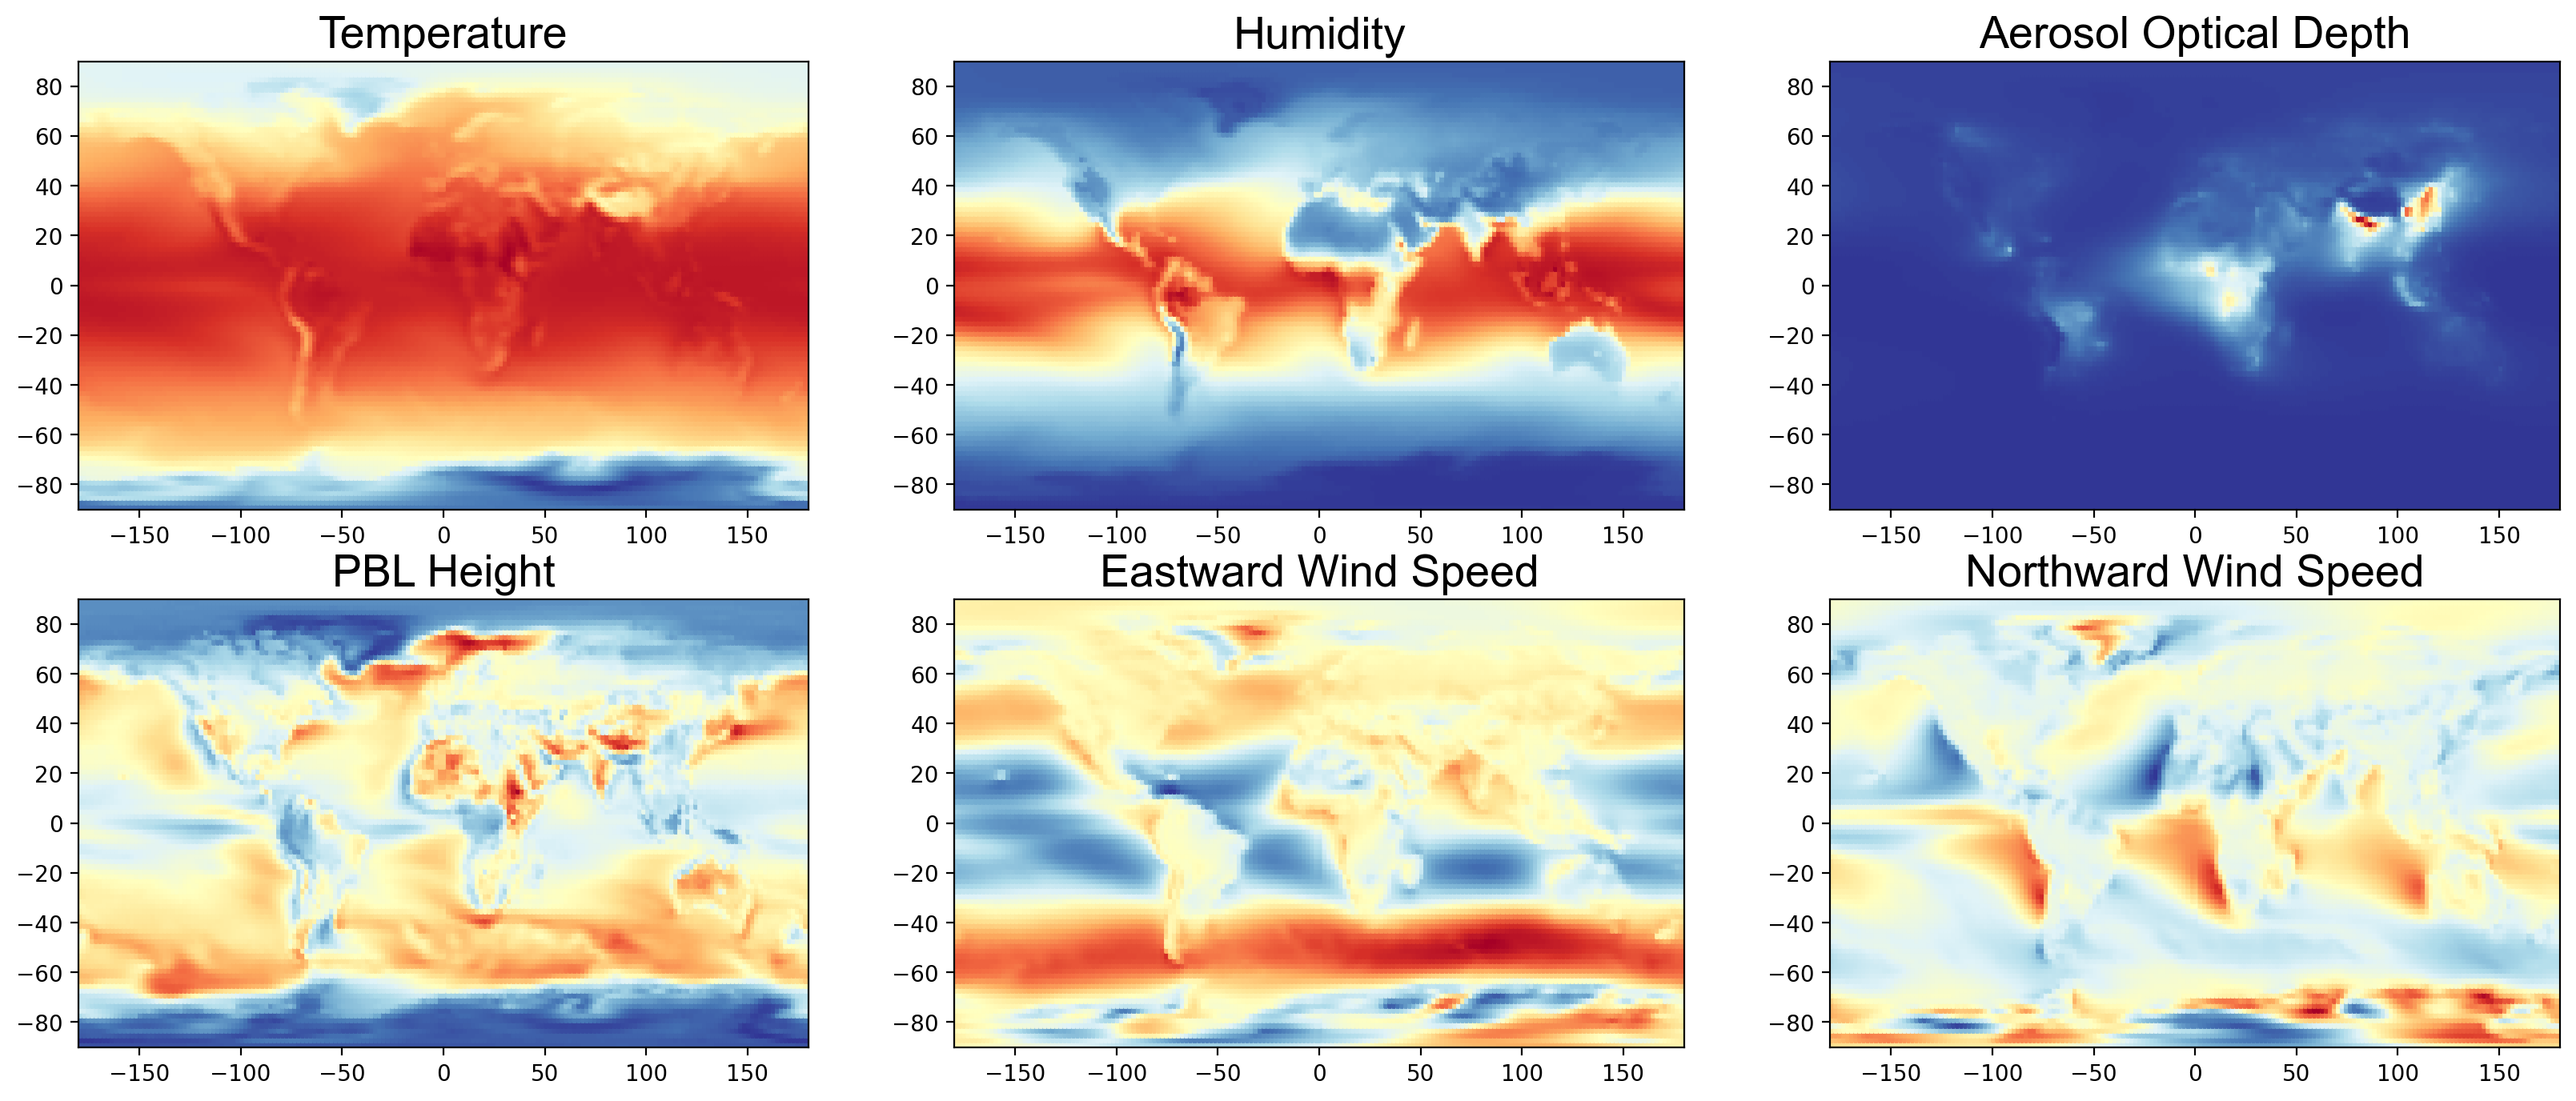

In [43]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('Temperature', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['tas'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('Humidity', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hus'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('Aerosol Optical Depth', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['aod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('PBL Height', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['bldep'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('Eastward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ua'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('Northward Wind Speed', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['va'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

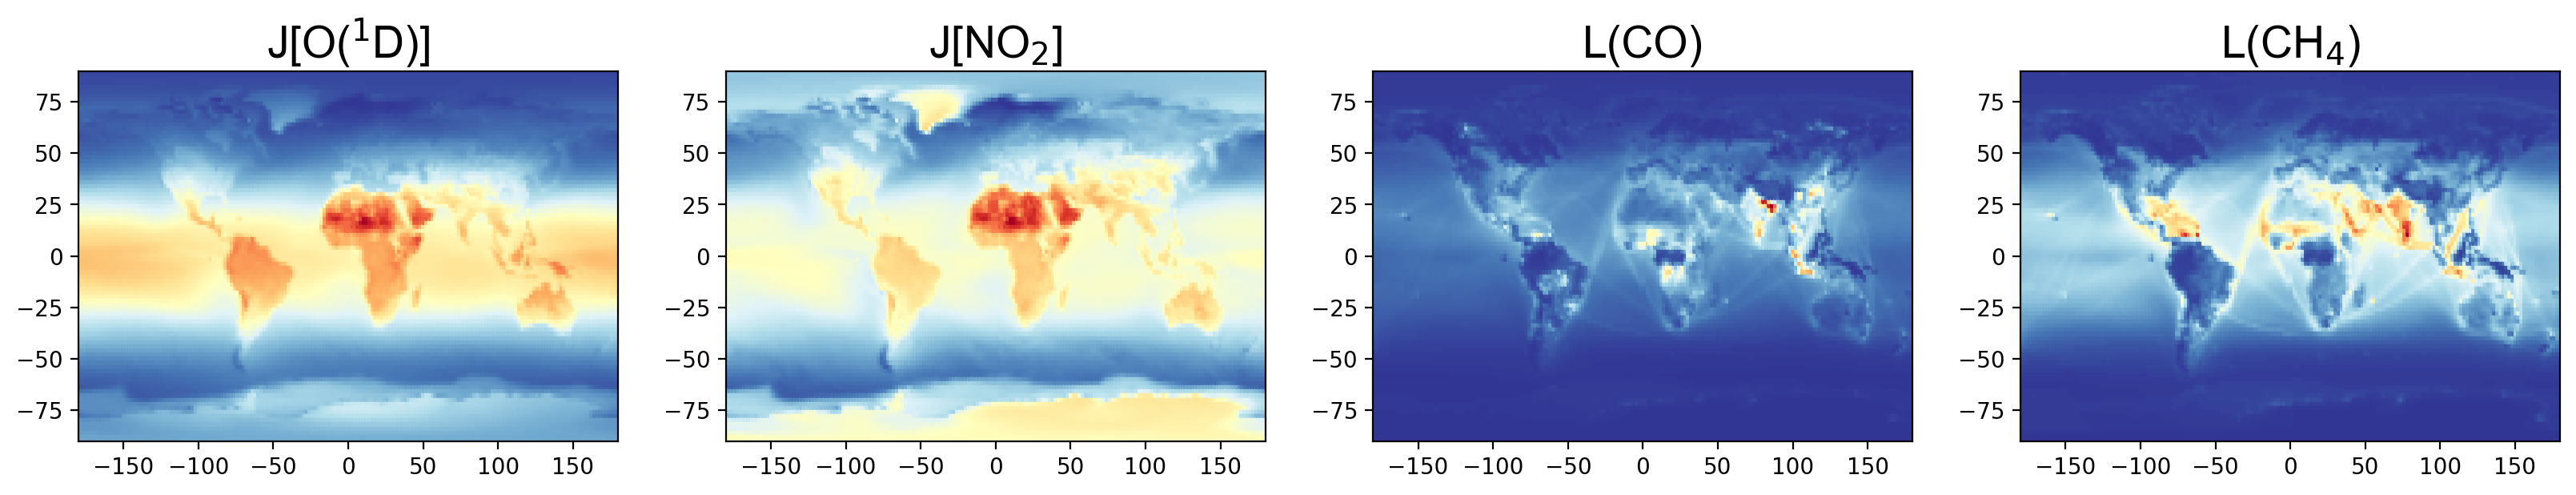

In [44]:
plt.figure(num=None, figsize=(20, 3), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(1,4,1)
plt.title('J[O(${^1}$D)]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['photo1d'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,2)
plt.title('J[NO${_2}$]', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['jno2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,3)
plt.title('L(CO)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossco'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,4,4)
plt.title('L(CH${_4}$)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['lossch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

In [45]:
plt.figure(num=None, figsize=(20, 8), dpi=200, facecolor='w', edgecolor='k')

plt.subplot(2,3,1)
plt.title('NO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no2'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,2)
plt.title('NO', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['no'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,3)
plt.title('OH', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['oh'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,4)
plt.title('H${_2}$O', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['h2o'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,5)
plt.title('HNO${_3}$', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['hno3'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(2,3,6)
plt.title('PAN', fontsize = 20, fontname = "Arial", color = "black")
z = np.log(temp['pan'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

(-90.0, 90.0)

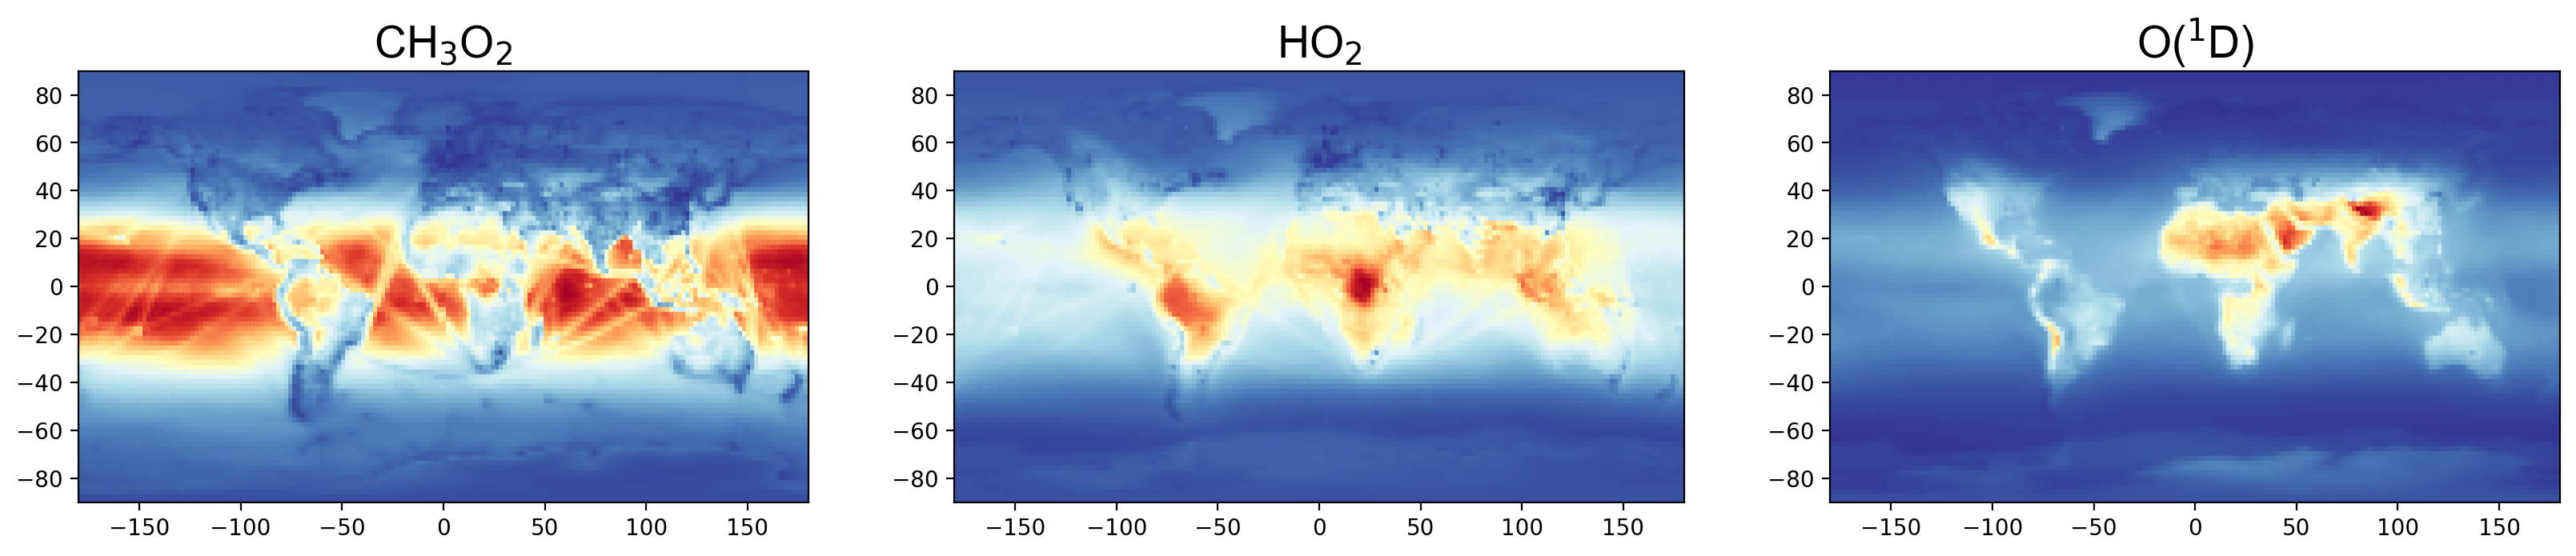

In [46]:
plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('CH${_3}$O${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ch3o2_mod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('HO${_2}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ho2_mod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('O(${^1}$D)', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['o1d_mod'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

(-90.0, 90.0)

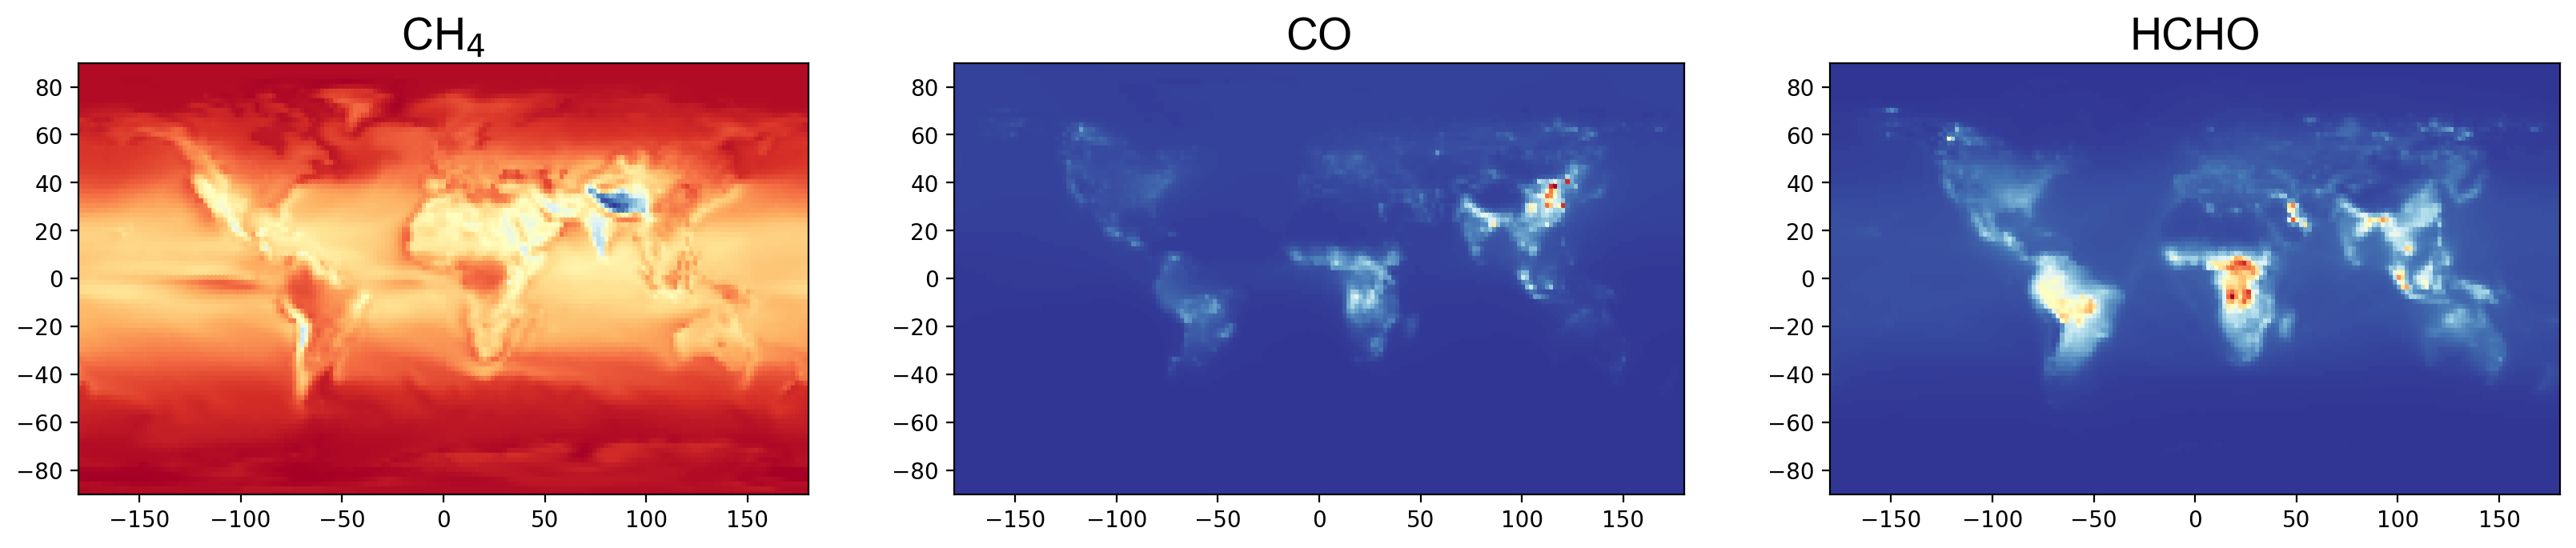

In [47]:
plt.figure(num=None, figsize=(20, 3.5), dpi=200, facecolor='w', edgecolor='k')
cm = plt.cm.get_cmap('RdYlBu_r')
x = temp['longitude']
y = temp['latitude']

plt.subplot(1,3,1)
plt.title('CH${_4}$', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['ch4'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,2)
plt.title('CO', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['co'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)

plt.subplot(1,3,3)
plt.title('HCHO', fontsize = 20, fontname = "Arial", color = "black")
z = (temp['hcho'])
sc = plt.scatter(x, y, c=z, marker="s", s=5, cmap=cm)
plt.xlim([-180, 180])
plt.ylim([-90, 90])
#plt.colorbar(fraction=0.02)